In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
cd drive/

/content/drive


In [0]:
cd My Drive

/content/drive/My Drive


In [0]:
cd NLP_Lab_3

/content/drive/My Drive/NLP_Lab_3


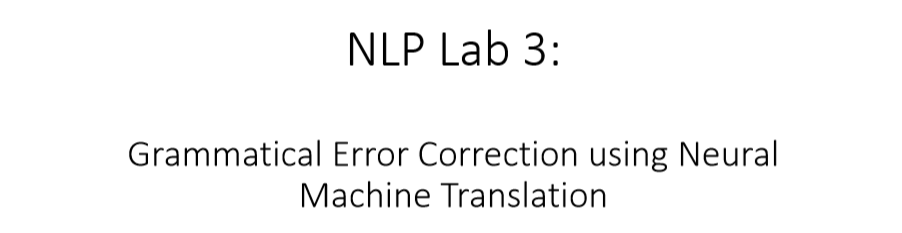

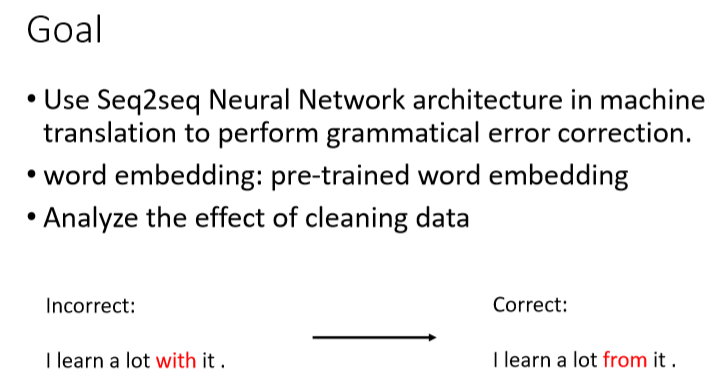

# Method 5
To reduce the dataset one other method that I have tried is to reduce the target and input sentences by only keeping the important parts that need to be modified. A sample of each of the error in the input sentence is taken and its target modification is taken. The problem with this model is that it requires a lot of time to figure out how what is the appropriate number of words that need to be taken for each sentence. A sentence can have many errors which means a on sentence can be broken into multiple sentences depending on the number of errors. For my model I ended with a max sentence length of 6, which allows for faster training. For prediction, the program takes a sentence as input and it needs to identify problem words in the sentence, take a sample, make a prediction, places the predicted sentence for in the original sentence. 


# Import libraries

In [0]:
#from __future__ import print_function
import nltk
nltk.download('punkt')
from nltk import word_tokenize
from keras.models import Model
from keras.layers import LSTM, Dense, Embedding, Input
import numpy as np
from gensim.models import KeyedVectors
from random import shuffle
from keras import optimizers

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Get smaller sentences

In [0]:
def get_imp(line,clean):
 num_neighbor_word_per_side=2
 input_sent= word_tonum_neighbor_word_per_sideenize(line[0])     
 target_sent= word_tonum_neighbor_word_per_sideenize(line[1]) 
 if Clean==True:
    target_sent=clean(target_sent)   
 position_input=0
 position_target=0 
 Targets=[]
 Inputs=[]
 for c in range(len(input_sent)):
    a1= 0
 # 1. checnum_neighbor_word_per_side if  word in target sentence at same position
    if c+1+position_target < len(target_sent) and c+1+position_input<len(input_sent): 
     if input_sent[c+position_input] != target_sent[c+position_target]:
        if input_sent[c+1+position_input] == target_sent[c+1+position_target]: 
        #  Update_dict(target_sent[c+position_target],input_sent[c+position_input])
          Inputs.append(    input_sent[   max(0,c+position_input-num_neighbor_word_per_side) : min( len(input_sent)-1,c+position_input+num_neighbor_word_per_side+1 )   ]    )
          Targets.append(target_sent[ max(c+position_target-num_neighbor_word_per_side, 0 ):min(len(target_sent)-1, c+position_target+num_neighbor_word_per_side+1)      ]      )
# 2.     if  
        elif input_sent[c+position_input] == target_sent[c+1+position_target]: 
        #     Update_dict(target_sent[c+position_target],'EMPTY')
             a1+=1
             Inputs.append(  input_sent[max (0,c+position_input-num_neighbor_word_per_side+1) : min(len(input_sent)-1, c+position_input+num_neighbor_word_per_side+1) ]    )
             Targets.append(  target_sent[max (0,c+position_target-num_neighbor_word_per_side) : min(len(target_sent)-1, c+position_target+num_neighbor_word_per_side+1) ]    )
            
        elif c+2+position_input<len(input_sent) :
         if target_sent[c+position_target+1]==input_sent[c+2+p1]:
         # Update_dict(target_sent[c+1+position_target],input_sent[c+position_input]+' '+input_sent[c+1+position_input])
          a1+=1
          Inputs.append( input_sent[max (0,c+position_input-K+1) : min(len(input_sent)-1, c+position_input+num_neighbor_word_per_side+1) ] )     
          Targets.append( target_sent[ max (0,c+1+position_target-num_neighbor_word_per_side) : min(len(target_sent)-1, c+position_target+num_neighbor_word_per_side)  ]  )
          breanum_neighbor_word_per_side
    position_target+=a1
 return Inputs, Targets

# Separate input and target data


In [0]:
def preprocessing(data_path,samples,Clean=False):
# Vectorize the data.
 input_texts = []
 target_texts = []
 input_words = set()
 target_word = set()
 with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')   
 lines = lines[: int(samples*len(lines)) - 1]
 array=np.arange(len(lines))
 shuffle(array)
 for num in range(len(lines)):
  line = lines[array[num]]
  if len(line)>0:
# 1.    Raw Data 
   Input_text, Target_text = get_imp(line.split('\t'),Clean)
   if len(Input_text)>0:
    for  c in range(len(Input_text)):
     input_text,target_text = Input_text[c], Target_text[c] 
     target_text = ['\t'] + target_text
     input_text = input_text + ['\n']

# 2.    Tokenize Data

     input_texts.append(input_text)
     target_texts.append(target_text)
     for word in input_text:
        if word not in input_words:
            input_words.add(word)
     for word in target_text:
        if word not in target_word:
            target_word.add(word)

 input_words = sorted(list(input_words))
 target_word = sorted(list(target_word))
 num_encoder_tokens = len(input_words)
 num_decoder_tokens = len(target_word)

 max_encoder_seq_length = max([len(txt) for txt in input_texts]) 
 max_decoder_seq_length = max([len(txt) for txt in target_texts]) 

 print('Number of samples:', len(input_texts))
 print('Number of unique input tokens:', num_encoder_tokens)
 print('Number of unique output tokens:', num_decoder_tokens)
 print('Max sequence length for inputs:', max_encoder_seq_length)
 print('Max sequence length for outputs:', max_decoder_seq_length)
 
# 3.        Build Vocab Dictionary

 #i,j=len(input_words),len(target_word)
 input_token_index = dict( [(word, i) for i, word in enumerate(input_words)])
 target_token_index = dict([(word, i) for i, word in enumerate(target_word)])
 
 return  input_texts,target_texts , input_token_index, target_token_index, max_encoder_seq_length,max_decoder_seq_length

# Change words to vectors using Word2Vec 

In [0]:
def get_dict(data):
    Dict=dict()
    for x in data:
     if x not in Dict:
      if x in WORD2VEC.vocab:       
          Dict[x]=WORD2VEC.wv[x]
      else:
        Dict[x]=np.zeros(300)  
    return Dict

# Pad data



In [0]:
def Pad_data(input_words,target_words):

 encoder_input_data = np.zeros(
    (len(input_words), MAX_ENCODER_SEQ_LENGTH),dtype='float32')
 
 decoder_input_data = np.zeros(
    (len(target_words), MAX_DECODER_SEQ_LENGTH),dtype='float32')
 
 decoder_target_data = np.zeros(
    (len(target_words), MAX_DECODER_SEQ_LENGTH,1),dtype='float32')

 for i, (input_text, target_text) in enumerate(zip(input_words, target_words)):
     
   for j, word in enumerate(input_text) :
    if word in input_token_index:
     encoder_input_data[i,j] = input_token_index[word]
    
    for k, word in enumerate(target_text):
     if word in target_token_index:
      index = target_token_index[word]

      decoder_input_data[i, k] = index
      if k > 0:
         decoder_target_data[i, k-1,0] = index

 return decoder_input_data, decoder_target_data,encoder_input_data

#Get embedding layer

In [0]:
def get_Embedding(Dict):
  
 num_words1=len(Dict)
 embedding_matrix1 = []
 for word, i in Dict.items():

      if word in WORD2VEC.vocab:       
          embedding_matrix1.append(WORD2VEC.wv[word])
      else:
        embedding_matrix1.append(np.random.rand(300))
 embedding_layer = Embedding(num_words1,
                  EMBEDDING_DIM,
                  weights = np.array([embedding_matrix1]),
                  trainable=[True | False])
 
 return embedding_layer


# Clean target data

#Clean every occurrence of false-positive data 
• {‘discuss about’, ‘explain about’, ‘mention about’, ‘describe about’} 


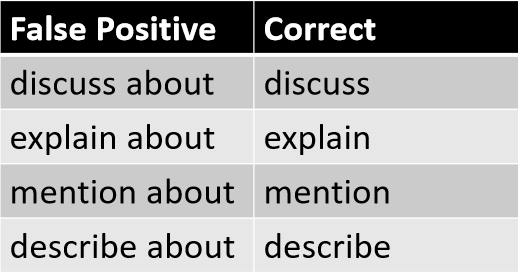







In [0]:
def clean(sent):
 s= ['discuss','explain', 'mention', 'describe']
 if 'about' in sent:
     loc = sent.index('about') - 1
     if  sent[loc] in s:
      sent = sent[:loc] + [sent[loc]] + sent[loc+2:]
 return sent

# Initialize values


In [0]:
WORD2VEC = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
EMBEDDING_DIM = 300  # Latent dimensionality of the encoding space.
samples = 1 # percentage of samples to train on.

# Get Train Data

In [0]:
input_texts, target_texts, input_token_index, target_token_index, MAX_ENCODER_SEQ_LENGTH,MAX_DECODER_SEQ_LENGTH = preprocessing('train.txt',samples,True)

decoder_input_data, decoder_target_data,encoder_input_data = Pad_data(input_texts,target_texts)


Number of samples: 167724
Number of unique input tokens: 20552
Number of unique output tokens: 19974
Max sequence length for inputs: 6
Max sequence length for outputs: 6


# Get Validation Data

In [0]:
val_input_texts,val_target_texts,_,_,_,_ = preprocessing('validation.txt',1,True)

val_input_data, val_target_data, val_encoder_input_data = Pad_data(val_input_texts,val_target_texts)


Number of samples: 41999
Number of unique input tokens: 10282
Number of unique output tokens: 10088
Max sequence length for inputs: 6
Max sequence length for outputs: 6


# Get Test Data

In [0]:
 with open('test1.txt', 'r', encoding='utf-8') as f:
    test = f.read().split('\n')
test = [word_tokenize(x) for x in test]

test_encoder_input_data = np.zeros(
    (len(test), MAX_ENCODER_SEQ_LENGTH),dtype='float32')

 for i in range(len(test)):
  for j in range(min(len(test[i]), MAX_ENCODER_SEQ_LENGTH ) ) :
   word = test[i][j] 
   if word in  input_token_index:
    test_encoder_input_data[i,j] = input_token_index[word]

# Get embedding matrix

In [0]:
embeddinglayer_1 = get_Embedding(input_token_index)
embeddinglayer_2 = get_Embedding(target_token_index)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


# Setup layers

We discard `encoder_outputs` and only keep the states.
Set up the decoder, using `encoder_states` as initial state.
We set up our decoder to return full output sequences,
and to return internal states as well. We don't use the
return states in the training model, but we will use them in inference.


In [0]:
encoder_inputs = Input(shape=(None, ))
lstm1_inputs = embeddinglayer_1(encoder_inputs)

encoder = LSTM(EMBEDDING_DIM, return_state=[True | False]) 
encoder_outputs, state_h, state_c = encoder(lstm1_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None,))
lstm2_inputs = embeddinglayer_2(decoder_inputs)

decoder_lstm = LSTM(EMBEDDING_DIM, return_sequences=[True | False],
                    return_state = [True | False])
decoder_output, _, _  = decoder_lstm(lstm2_inputs ,initial_state=encoder_states)

decoder_dense = Dense(len(target_token_index), activation='softmax')

decoder_outputs = decoder_dense(decoder_output)



# Setup Model
Define the model that will turn
`encoder_input_data` & `decoder_input_data` into `decoder_target_data`

In [0]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
rmsprop = optimizers.Adam(lr=0.0005)
model.compile(optimizer= rmsprop, loss='sparse_categorical_crossentropy')
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, None, 300)    6165900     input_7[0][0]                    
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, None, 300)    5992500     input_8[0][0]                    
____________________________________________________________________________________________

# Run training


In [0]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=1000,
         epochs=50,
          validation_data=([val_encoder_input_data, val_input_data],
                            val_target_data))

Train on 167724 samples, validate on 41999 samples
Epoch 1/50
167724/167724 [==============================] - 26s 153us/step - loss: 1.7090 - val_loss: 1.7177
Epoch 2/50
167724/167724 [==============================] - 26s 153us/step - loss: 1.6000 - val_loss: 1.6318
Epoch 3/50
167724/167724 [==============================] - 26s 153us/step - loss: 1.5007 - val_loss: 1.5492
Epoch 4/50
167724/167724 [==============================] - 26s 152us/step - loss: 1.4041 - val_loss: 1.4708
Epoch 5/50
167724/167724 [==============================] - 26s 152us/step - loss: 1.3104 - val_loss: 1.3953
Epoch 6/50
167724/167724 [==============================] - 26s 152us/step - loss: 1.2202 - val_loss: 1.3241
Epoch 7/50
167724/167724 [==============================] - 26s 152us/step - loss: 1.1341 - val_loss: 1.2594
Epoch 8/50
167724/167724 [==============================] - 26s 153us/step - loss: 1.0518 - val_loss: 1.1974
Epoch 9/50
167724/167724 [==============================] - 26s 153us/step - 

# Save Model

In [0]:
#model.save('model100.h5')
model = load_model('model100.h5')

# Encoder inference model


In [0]:
encoder_model = Model(encoder_inputs, encoder_states)
encoder_model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_9 (Embedding)      (None, None, 300)         6165900   
_________________________________________________________________
lstm_5 (LSTM)                [(None, 300), (None, 300) 721200    
Total params: 6,887,100
Trainable params: 6,887,100
Non-trainable params: 0
_________________________________________________________________


# Decoder inference model


In [0]:
decoder_state_input_h =  Input(shape=(EMBEDDING_DIM,)) 
decoder_state_input_c =  Input(shape=(EMBEDDING_DIM,)) 
decoder_states_inputs =  [decoder_state_input_h, decoder_state_input_c]

decoder_out, state_h1, state_c1 = decoder_lstm(embeddinglayer_2(decoder_inputs) ,initial_state = decoder_states_inputs)

decoder_states = [state_h1, state_c1]
decoder_out = decoder_dense(decoder_out)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_out] + decoder_states)

decoder_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, None, 300)    5992500     input_8[0][0]                    
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 300)          0                                            
____________________________________________________________________________________________

# Reverse-lookup token index to decode sequences back to something readable.


In [0]:
reverse_input_word_index = dict(
    (i, word) for word, i in input_token_index.items())
reverse_target_word_index = dict(
    (i, word) for word, i in target_token_index.items())

# Decode sentence

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros( (1, 1)) #len(target_token_index))  #np.zeros((1, 1))
    # Populate the first wordacter of target sequence with the start wordacter.
    target_seq[0, 0] = target_token_index['\t'] #

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ['']
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens [0, 0]) 
        sampled_word = reverse_target_word_index[sampled_token_index]
        decoded_sentence += [sampled_word]
        #print( sampled_word )
        # Exit condition: either hit max length
        # or find stop wordacter.
        #if (sampled_word == '\n' or
        if  len(decoded_sentence) > MAX_DECODER_SEQ_LENGTH:  # MAX_DECODER_SEQ_LENGTH
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))     #len(target_token_index))  #         (1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return list(filter(None, decoded_sentence))

# Testing...

In [0]:
for seq_index in range(10,19):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    target_seq = target_texts[seq_index][1:]
    decoded_sentence = decode_sequence(input_seq)

    print('------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Input sentence:', ' '.join(input_texts[seq_index]))
    print('Decoded sentence:', ' '.join(decoded_sentence))
    print('Target sentence:', ' '.join(target_seq))

------------------------------------------------------------------------------------------------------------------------------------------------------------
Input sentence: and 7o'clock in the 

Decoded sentence: , and at 7o'clock in 	
Target sentence: , and at 7o'clock in
------------------------------------------------------------------------------------------------------------------------------------------------------------
Input sentence: job was on HP , 

Decoded sentence: job was at HP , 	
Target sentence: job was at HP ,
------------------------------------------------------------------------------------------------------------------------------------------------------------
Input sentence: a doctor for help people 

Decoded sentence: a doctor to help people 	
Target sentence: a doctor to help people
------------------------------------------------------------------------------------------------------------------------------------------------------------
Input sentence: Ireland 

# Test validation

In [0]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = val_encoder_input_data[seq_index: seq_index + 1]
    target_seq = val_target_texts[seq_index][1:]
    decoded_sentence = decode_sequence(input_seq)

    print('------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Input sentence:', ' '.join(val_input_texts[seq_index]))
    print('Decoded sentence:', ' '.join(decoded_sentence))
    print('Target sentence:', ' '.join(target_seq))

------------------------------------------------------------------------------------------------------------------------------------------------------------
Input sentence: get fitness 6 p.m 

Decoded sentence: I get to 6 fitness 	
Target sentence: I get to fitness at
------------------------------------------------------------------------------------------------------------------------------------------------------------
Input sentence: fitness 6 p.m 

Decoded sentence: back playing at 7 p.m 	
Target sentence: to fitness at 6 p.m
------------------------------------------------------------------------------------------------------------------------------------------------------------
Input sentence: like make friends with 

Decoded sentence: I like to make friends 	
Target sentence: I like to make friends
------------------------------------------------------------------------------------------------------------------------------------------------------------
Input sentence: to buy in

# Predict test data

In [0]:
def make_prediction(test_encoder_input_data):
 Ans=[]
 for seq_index in range(5):#len(test_encoder_input_data)):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = test_encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('----------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Input sentence:', ' '.join(input_texts[seq_index]),)
    print('Decoded sentence:', ' '.join(decoded_sentence))    
    Ans.append(' '.join(decoded_sentence))
 return Ans


In [0]:
Ans = make_prediction(test_encoder_input_data)
